# Lab Sheet 1: PySpark Demo and Word Counting with Spark

To get you started, we'll walk you through a bits of PySpark code, and then we'll do the classic word count example, followd by some tasks for you to try.

**Please run through the notebook cell by cell (using 'run' above or 'shift-return' on the keyboard).**

## Part 1 - Demo: Apapche Spark API with PySpark

Basically there are 3 API's available in Apache Spark - RDD (Resilient Distributed Datasets), DataFrame and Dataset. In this lab we will look at RDDs and Dataframes.

For more information on the Spark framework - visit (https://spark.apache.org)
For more information on the Pyspark API - visit (https://spark.apache.org/docs/latest/api/python/index.html)

### 1) Access to Spark

The PySpark notebook environment provides SparkSession object called `spark`. From there we can get the SparkContext, normally called `sc`, which we use to create RDDs.

In [59]:
# predifined spark session
print(spark) 
# get the context
sc = spark.sparkContext
print(sc)

### 2) RDD Creation

There are two ways to create RDDs. The first is to parallelise a Python object that exists in your driver process (i.e. this one). 

The second way to create an RDD is by referencing an external dataset such as a shared filesystem, HDFS, HBase, or any data source offering a Hadoop InputFormat. This is what we will be using in this lab (further down).

In [60]:
# Creat an RDD from a Python object in this process (the "driver").
# The parallelize function  creating the "numbers" RDD
data = [1,2,3,4,5]
firstRDD = sc.parallelize(data)
print(firstRDD)

ParallelCollectionRDD[138] at parallelize at PythonRDD.scala:475


This RDD lives now on as many worker machines as are available and as are deemed useful by Spark.

### 3) RDD operations
RDDs have two kinds of operations: *Transformations* and *Actions*.

*Transformations* create a new RDD by applying a function to the items in the RDD. The function will only be applied when needed ("*lazy* evaluation").

*Actions* produce some output from the data. An *Action* will trigger the execution of all *Transformations*.

Here are some examples:

In [61]:
# lambda function: x -> x+3
RDD2 = firstRDD.map(lambda x:x+3)  
print(RDD2)
# nothing happened to far, as there is no action

PythonRDD[139] at RDD at PythonRDD.scala:48


In [62]:
# "count" is an action and triggers the transformation   
a = RDD2.count() 
print(a)

5


`collect` is an action that returns the values of the RDD in an Python array, back into this local driver process.

In [63]:
a = RDD2.collect() 
print(a)

[4, 5, 6, 7, 8]


Look here for more information about the functions provided by RDD: (https://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD). 

### 4) Dataframes 

Dataframes are a more structured form of data storage than RDDs, similar to Pandas dataframes.  

Let us see how to create and use dataframes. There are three ways of creating a dataframe
    a) Loading data from an existing RDD.
    b) It can be created form and external data source. For example, loading the data from JSON or CSV files.
    c) Programmatically specifying schema.
    
Here is an example for option a.

In [64]:
from pyspark.sql import Row

list = [('Anne',21),('Bob',22),('Carl',29),('Daisy',36)]
rdd = sc.parallelize(list)
peopleRDD = rdd.map(lambda x: Row(name=x[0], age=int(x[1])))
peopleDF = sqlContext.createDataFrame(peopleRDD) 
print(peopleDF)

DataFrame[age: bigint, name: string]


### 5) Visualisation with Pixiedust

The pixiedust library provides a visual display of DataFrames, so we can use it to view the data.


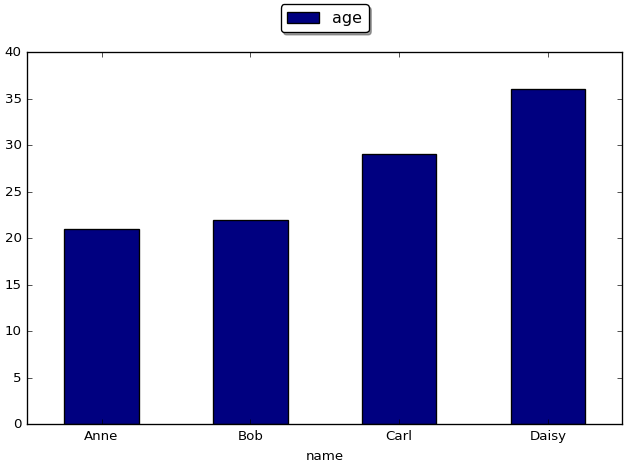

In [65]:
import pixiedust
display(peopleDF)

## Part 2: Classic Word Count

We will now do the classic word count example for the MapReduce pattern.

We will apply it to the text of Sheakespeare's play *Hamlet*. For that you should have uploaded the file "hamlet.txt" into the data assets. If you don't have it, please follow the instructions in the *IBM project setup guide* on Moodle.

### 6) Load the data
First we need to load the text into an RDD (the second method of creating an RDD as mentioned above). 

For this, go to the *Data* sidebar and select from *Insert to code* the option *Insert SparkSession Setup* below.  

In [35]:
# insert code to access "hamlet.txt" here

You should have a variable `path_1` or similar, from which you can read the file into an RDD with `textFile`. The RDD then contains as items the lines of the text. `take(3)` then gives us the first 3 lines.  

In [87]:
lineRDD = sc.textFile(path_1)
lineRDD.take(3)

['Project Gutenberg Etext of Hamlet by Shakespeare',
 "PG has multiple editions of William Shakespeare's Complete Works",
 '']

### 7) Split lines into words

In order to count the words, we need to split the lines into words. We can do that using the `split` function of the Python String class to separate at each space. 

The map function replaces each item with a new one, in this case our `lambda` returns an array of words (provided by `split(' ')`). However, we want to create one item per word, therefore we need to use a function called `flatMap` that creates a new RDD item for every item in the array returned by the lambda.  

In [91]:
wordRDD = lineRDD.flatMap(lambda x: x.split(' '))
wordRDD.take(3)

['Project', 'Gutenberg', 'Etext']

Map the words to tuples of the form *(word, 1)*.

In [46]:
word1RDD = wordRDD.map(lambda x: (x, 1))
word1RDD.take(3)

[('Project', 1), ('Gutenberg', 1), ('Etext', 1)]

### 8) Count by reducing
For Spark, the first part in each tuple is the 'key'. Now we can use reduceByKey() to add the 1s and get the number of occurences per word.

In [66]:
wordCountRDD = word1RDD.reduceByKey(lambda x,y: x+y )
wordCountRDD.take(3)

[('', 2290), ('fire!', 1), ('historical-pastoral,', 1)]

### 9) Filtering and visualisation

There are many empty strings returned by the splitting. We can remove them by filtering.
Then can take a shortcut and use a ready-made functions 'count by value', which does the same as we before.

In [82]:
wordFilteredRDD = wordRDD.filter(lambda x: len(x)>0)
word1RDD = wordFilteredRDD.map(lambda x: (x, 1))
wordCountRDD = word1RDD.reduceByKey(lambda x,y: x+y )
wordCountRDD.take(3)

[('ourselves.--[To', 1), ('historical-pastoral,', 1), ('heedful', 1)]


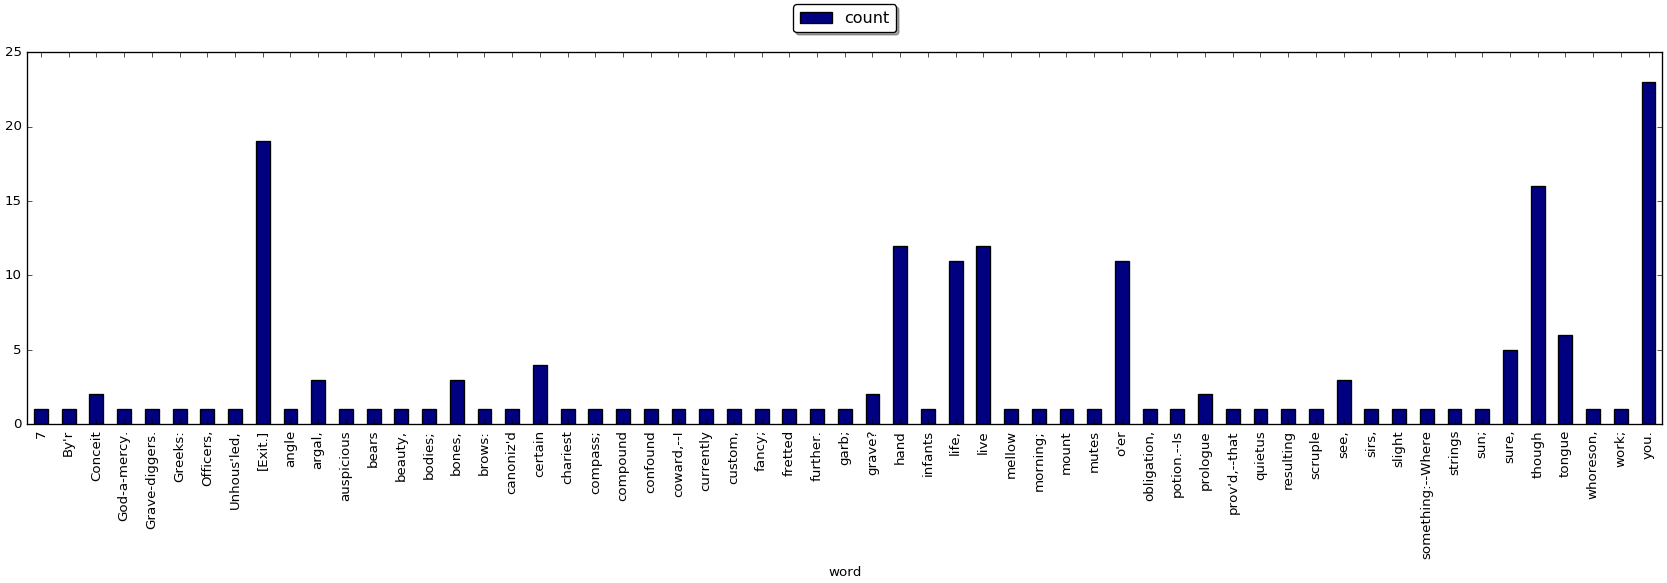

In [83]:
wordCountRows = wordCountRDD.map(lambda x: Row(word=x[0], count=int(x[1])))
wordCountDF = sqlContext.createDataFrame(wordCountRows) 
display(wordCountDF)

## Part 3: Tasks for you to work on

Based on the examples above, you can now write some code yourself. 

## 1) Better splitting 

As you may have seen, currently our 'words' contain punctuation. A better was to split is using regular expressions  (Python's 're' package)(https://docs.python.org/3.5/library/re.html?highlight=regular%20expressions). `re.split('\W+', 'my. test. string!')` does a better job. Try it out below by fixing the line that starts with '>>>'.

In [107]:
import re
#>>> wordRDD = lineRDD.flatMap(lambda x: ...) # apply re.split('\W+', string) here
wordRDD = lineRDD.flatMap(lambda x: re.split('\W+', x)) # apply re.split('\W+', string) here
wordFilteredRDD = wordRDD.filter(lambda x: len(x)>0) # do the filtering
wordFilteredRDD.take(3)

['Project', 'Gutenberg', 'Etext']

## 2) Use lower case

Modify the map call (4th line) to convert all strings to lower case (using `.lower()` provided by the Python string class).

In [111]:
wordLowerRDD = wordFilteredRDD.map(lambda x: (x.lower(), 1))
wordLowerRDD.take(3)

[('project', 1), ('gutenberg', 1), ('etext', 1)]

In [112]:
wordCountRDD = wordLowerRDD.reduceByKey(lambda x,y: x+y)
wordCountRDD.take(3)

[('was', 88), ('incontinency', 1), ('rotten', 2)]

## 3) Filter rare words

Add a filtering step call remove all words with less than 5 occurrences. 

This can be useful to identify common topics in documents, where very rare words can be misleading. 

In [119]:
# the trick here is to apply the lambda only to the second part of each item, i.e. x[1] 
#>>> freqWordsRDD = wordCountRDD.filter(lambda x:  ... )
freqWordsRDD = wordCountRDD.filter(lambda x:  x[1] >= 5 )
freqWordsRDD.take(3)


[('was', 88), ('law', 9), ('proof', 6)]

## 4) List only stopwords

Stopwords are frequent words that are not topic-specifc.  Stopwords can be useful for recognising the style of an author. Removing stopwords can be useful in regocnising the topic of a document. 

Below is a small list of stopwords. Filter the tuples where the first part is a stopword.

In [120]:
stopWordList = ['the','a','in','of','on','at','for','by','I','you','me'] 
stopWordsRDD = freqWordsRDD.filter(lambda x:  x[0] in stopWordList) 

There are only a few words, so we can see the vies results. 

In [121]:
output = stopWordsRDD.collect() 
for (word, count) in output:
    print("%s: %i" % (word, count))

at: 99
of: 733
in: 464
by: 147
a: 582
for: 277
the: 1218
me: 236
you: 610
on: 150


We can now visualise the stopword counts.


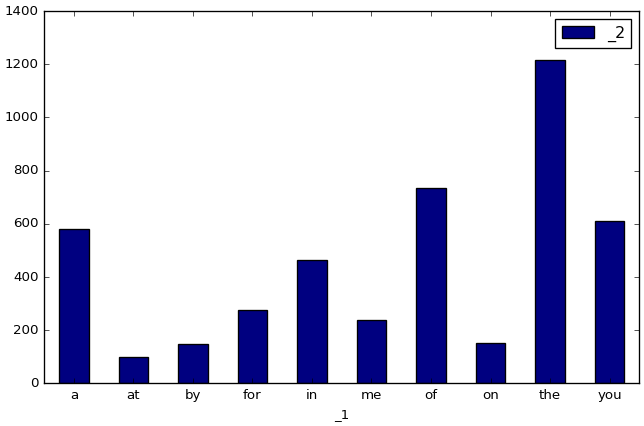

In [122]:
df2 = sqlContext.createDataFrame(output)
display(df2)

### 5) Reading

Read chapter 1 of Lescovec et al (2014), "Mining of Massive Datasets", and work out the answers to exercise 1.2.1 on page 7 and 1.3.1 and 1.3.2 on page 15. If you have time, start reading chapter 2.

### 6) Spark @home (recommended)

Install Spark on your own laptop or desktop, using the instructions provided on Moodle.